In [1675]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
import itertools
from icecream import ic

logging.basicConfig(level=logging.DEBUG)

In [1676]:
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))

for c1, c2 in combinations(CITIES.itertuples(), 2):
    # This is doing two assignments at once because the distance from city A to city B is the same as the distance from city B to city A. Let's break it into steps:
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()
print(DIST_MATRIX)



[[  0.         349.30401144 391.04186819 ... 223.61470849 285.67481712
  266.79616501]
 [349.30401144   0.          50.17877215 ... 566.29615596 634.93310475
  614.95900451]
 [391.04186819  50.17877215   0.         ... 604.01577185 676.49916849
  654.72206469]
 ...
 [223.61470849 566.29615596 604.01577185 ...   0.         104.8569216
   63.17924401]
 [285.67481712 634.93310475 676.49916849 ... 104.8569216    0.
   44.69517255]
 [266.79616501 614.95900451 654.72206469 ...  63.17924401  44.69517255
    0.        ]]


## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

## Fast Greedy Algorithm 


In [1677]:
current_city = 0  # Starting city (you can choose any starting point)
visited = [False] * len(DIST_MATRIX)  # Initialize visited list
visited[current_city] = True  # Mark the starting city as visited
total_distance = 0  # To accumulate total distance

# Loop until all cities are visited
while not all(visited):
    min_value = np.inf
    min_index = -1

    for j in range(len(DIST_MATRIX[current_city])):  # Loop through cities from the current city
        if DIST_MATRIX[current_city, j] < min_value and not visited[j] and DIST_MATRIX[current_city, j] != 0:
            min_value = DIST_MATRIX[current_city, j]
            min_index = j

    if min_index != -1:  # Check if a minimum index was found
        visited[min_index] = True  # Mark the new city as visited
        total_distance += min_value  # Add the distance to total
        current_city = min_index  # Update the current city to the newly found city
        
    if all(visited):
        total_distance += DIST_MATRIX[current_city, 0]
        print(f'Total distance: {total_distance} km')


Total distance: 4436.03176952516 km


## Evolutionary Algorithm

For initialization, we start by creating a population of random paths. Each path will be a random permutation of the city indices, representing a unique route. We create population_size number of paths.

In [1678]:
population_size = 100 # number of paths in each generation
num_cities = len(CITIES) # number of cities
print(num_cities)
population = [np.random.permutation(num_cities) for _ in range(population_size)] # Here we are generating 100 paths of 10 cities each. We can also generate the maximum num
# of possible permutations. which will be !numOfCities permutations. we will try this later.
# Wouldn't make sense to consider the maximum number of permutations. It would be too much. for 46 cities it will be 46! which is 5502622159812088949850305428800254892961651752960000000000

46


We can say that the total distance of a unique path is it's fitness. This way we can rank the permutations based on the total distance and aim for the shorter ones. 

In [1679]:
def calculate_path_distance(path):
    distance = 0
    for i in range(len(path) - 1):
        distance += DIST_MATRIX[path[i], path[i + 1]]
    # Return to the starting point
    distance += DIST_MATRIX[path[-1], path[0]]
    return distance

# Calculate fitness for each path in the population
fitness_scores = [calculate_path_distance(path) for path in population]
# now we sort based on the minimum distance 


print(min(fitness_scores))


15294.569700889238


### Selection Process

In selection we will select the paths (solutions) that we will use to create the next generation. We want to favor the paths with lower distances (higher fitness) while still allowing some randomness to maintain diversity. 
We do the Roulette Wheel Selection:

We assign probability based on the fitness, higher fitness will get a higher probability so they are more likely to be selected. 

In [1680]:
# Basic ROulette Wheel Selection
def select_parents(population, fitness_scores, num_parents=population_size):
    # calculate the probability of each individual(path) being selected
    total_fitness = sum(1/score for score in fitness_scores)
    selection_probs = [(1/score) / total_fitness for score in fitness_scores]
    # here we select the parents based on probabilities
    parents_indices = np.random.choice(len(population), size = num_parents, p = selection_probs)
    parents = [population[i] for i in parents_indices]
    return parents

In [1681]:
# Tournament Selection

def select_parents(population, fitness_scores, num_parents, tournament_size=3):

    selected_parents = []
    
    for _ in range(num_parents):
        # Randomly select tournament_size individuals
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]
        
        # Select the best from the tournament (minimum distance for TSP)
        winner_idx = tournament_indices[np.argmin(tournament_fitness)]
        selected_parents.append(population[winner_idx])
    
    return selected_parents



In [1682]:
## Rank Based Selection
def select_parents(population, fitness_scores, num_parents):

    # Sort indices by fitness (ascending since lower distance is better)
    ranked_indices = np.argsort(fitness_scores)
    
    # Calculate rank-based probabilities (higher rank = higher probability)
    ranks = np.arange(len(population), 0, -1)
    selection_probs = ranks / ranks.sum()
    
    # Select parents based on rank probabilities
    parent_indices = np.random.choice(
        len(population), 
        size=num_parents, 
        p=selection_probs,
        replace=False  # Ensure unique parents
    )
    
    return [population[i] for i in parent_indices]


### Crossover 
Here we combine two parent paths to create a new child path. The idea is that to inherit traits from each parent to explore new combinations of cities while keeping some order. 

In [1683]:
# Basic order crossover
def crossover(parent1, parent2):
    # choose crossover points 
    point1, point2 = sorted(np.random.choice(len(parent1), 2, replace=False))
    # child starts with slice of parent1 
    child = [-1]*len(parent1)
    child[point1:point2] = parent1[point1:point2]

    # Fill the remaining cities from parent2 while avoiding dupication
    for i in range(len(parent2)):
        if parent2[i] not in child:
            for j in range(len(child)):
                if child[j] == -1:
                    child[j] = parent2[i]
                    break
    return child

In [1684]:
import random
def edge_recombination_crossover(parent1, parent2):
  
    n = len(parent1)
    # Create edge map for both parents
    edge_map = {i: set() for i in range(n)}
    
    # Build edge map from both parents
    for parent in [parent1, parent2]:
        for i in range(n):
            edge_map[parent[i]].add(parent[(i + 1) % n])
            edge_map[parent[i]].add(parent[(i - 1) % n])
    
    # Generate child
    child = [-1] * n
    current = parent1[0]  # Start with first city of parent1
    child[0] = current
    
    # Fill remaining cities
    for i in range(1, n):
        # Remove current city from all neighbor lists
        for j in edge_map:
            edge_map[j].discard(current)
            
        # Get neighbors of current city
        neighbors = edge_map[current]
        
        if neighbors:
            # Choose neighbor with fewest remaining neighbors
            next_city = min(neighbors, key=lambda x: len(edge_map[x]))
        else:
            # If no neighbors, choose random unvisited city
            unused = set(range(n)) - set(child[:i])
            next_city = random.choice(list(unused))
            
        child[i] = next_city
        current = next_city
        
    return child

In [1685]:
# PMX Crossover
def pmx_crossover(parent1, parent2):

    n = len(parent1)
    # Choose crossover points
    point1, point2 = sorted(random.sample(range(n), 2))
    
    # Initialize offspring
    offspring = [-1] * n
    
    # Copy segment from parent1
    offspring[point1:point2] = parent1[point1:point2]
    
    # Create mapping
    mapping = dict(zip(parent1[point1:point2], parent2[point1:point2]))
    reverse_mapping = dict(zip(parent2[point1:point2], parent1[point1:point2]))
    
    # Fill the rest using mapping
    for i in range(n):
        if i < point1 or i >= point2:
            current = parent2[i]
            while current in mapping:
                current = mapping[current]
            offspring[i] = current
            
    return offspring

In [1686]:
def cycle_crossover(parent1, parent2):

    n = len(parent1)
    offspring = [-1] * n
    
    # Find cycles
    cycle = 0
    pos = 0
    while -1 in offspring:
        if offspring[pos] == -1:
            cycle += 1
            current = pos
            while True:
                # Copy from parent1 for odd cycles, parent2 for even
                offspring[current] = parent1[current] if cycle % 2 else parent2[current]
                current = list(parent1).index(parent2[current])
                if current == pos:
                    break
                    
        pos = (pos + 1) % n
        
    return offspring

### Mutation 
Mutation helps to introduce small changes in individual paths to maintain diversity. This prevents the algorithm from getting stuck in a local minimum. 


In [1687]:
def mutate(path, mutation_rate):
    if np.random.rand() < mutation_rate:
        # choose two random cities and swap them
        idx1, idx2 = np.random.choice(len(path), 2, replace=False)
        path[idx1], path[idx2] = path[idx2], path[idx1]
    return path

In [1688]:
def scramble_mutation(path, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        # Select two random points for the subset
        point1, point2 = sorted(np.random.choice(len(path), 2, replace=False))
        # Scramble the subset
        subset = path[point1:point2+1]
        np.random.shuffle(subset)
        # Replace the subset in the original path
        path[point1:point2+1] = subset
    return path

In [1689]:
def inversion_mutate(path, mutation_rate):
    if np.random.rand() < mutation_rate:
        # Select two random points for the subset
        point1, point2 = sorted(np.random.choice(len(path), 2, replace=False))
        # Reverse the subset
        path[point1:point2+1] = path[point1:point2+1][::-1]
    return path

In [1690]:
def adaptive_mutation_rate(initial_rate, final_rate, current_generation, total_generations):
    return initial_rate - (initial_rate - final_rate) * (current_generation / total_generations)

### Next Generation
Using the selection, crossover, and mutation functions, we generate a new generation of paths.
Here we combine tournament selection and elitism for the next generation


In [1691]:
import random

def generate_new_population(parents, mutation_rate=0.3, elite_size=5):
    new_population = []
    
    # Preserve the best paths (elitism)
    sorted_parents = sorted(parents, key=calculate_path_distance)
    new_population.extend(sorted_parents[:elite_size])
    
    # Generate the rest of the population using random selection
    while len(new_population) < len(parents):
        parent1 = random.choice(parents)
        parent2 = random.choice(parents)
        child = pmx_crossover(parent1, parent2)
        child = inversion_mutate(child, mutation_rate)
        new_population.append(child)
    
    return new_population

### Final Iteration
Here we combine all the steps and iterate for a set number of generations or until convergence. 

best distance: 4193.685940199698 found at generation: 3060


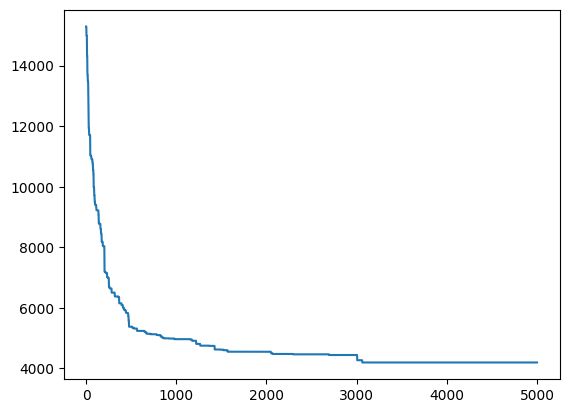

In [1692]:
num_generations = 5000  # Here we define the number of generations 
best_distances = []
best_generation = -1
best_distance = np.inf
# initial_mutation_rate = 0.5  # Starting mutation rate
# final_mutation_rate = 0.01  # Ending mutation rate


for generation in range(num_generations):
    # step 1: calculate fitness
    fitness_scores = [calculate_path_distance(path) for path in population]
    
    # step 2: Selection
    parents = select_parents(population, fitness_scores, 20)
    
    # step 2.1: adaptive mutation rate is used to control the mutation rate
    # mutation_rate = adaptive_mutation_rate(initial_mutation_rate, final_mutation_rate, generation, num_generations)
    
    # step 3: Generate new population
    population = generate_new_population(parents)

    # step 4: Calculate the best path in the current generation
    current_best_distance = min(fitness_scores)
    best_distances.append(best_distance)

    # step 5: Update the best generation
    if current_best_distance < best_distance:
        best_distance = current_best_distance
        best_generation = generation 

import matplotlib.pyplot as plt
plt.plot(best_distances)
print(f"best distance: {best_distance} found at generation: {best_generation}")